In [5]:
!pip install neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.9 MB/s eta 0:00:00


In [6]:
#Neptune
import neptune
# imports for downloading files
import glob
import os
import random
import time
import urllib.request
import zipfile
import csv

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

#  imports for the network
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

In [7]:
#Prepare neptune
run = neptune.init_run(
    project="FLAME-SCOUT/FLAME-SCOUT-seg",
    # Anders
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4MGI4ZWI5Zi1kZjBhLTQ3YzQtYjU0Yy03NTMxMjhmNWZhYjYifQ==",

    # José
    # api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMGUxMzgzYi02NTkyLTQ2MDgtOGQxMy0wNGU2YTUzOWNlYzQifQ==",
)  # your credentials

parameters = {
    "activation": "relu",
    "batch_size": 32,
    "n_epochs": 15,
    "learning_rate": 0.001,
}
run["model/parameters"] = parameters

<ipython-input-7-cf80e82ea0fa>:2: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(


https://app.neptune.ai/FLAME-SCOUT/FLAME-SCOUT-seg/e/FLMS-79


In [8]:
# Get files in current working directory
files = os.listdir()

# This url points to the download of the .zip file for the masks
masks_url = "https://onedrive.live.com/download?resid=AF45414AB81A52DC%21103772&authkey=!AGJ4SJC5qkrxV1g"

# This url points to the download of the .zip file for the masks
images_url = "https://onedrive.live.com/download?resid=AF45414AB81A52DC%21103773&authkey=!APqTtJD3wiy7Tpc"

urls =  [masks_url, images_url]

if "Images" not in files or "Masks" not in files:
    for url in urls:
        # Download the zip file
        print("Downloading zip file...")
        u = urllib.request.urlopen(url)
        data = u.read()
        u.close()

        zip_filename = ""
        if url == masks_url:
            # Specify the local filename for the downloaded zip file
            zip_filename = 'Masks.zip'
        elif url == images_url:
            # Specify the local filename for the downloaded zip file
            zip_filename = 'Images.zip'

        with open(zip_filename, 'wb') as f:
            f.write(data)

        # Unzip the downloaded file
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            # Extract all contents to the current working directory
            zip_ref.extractall()


In [9]:
class FireDataset(Dataset):

    def __init__(self, image_path,masks_path, transform):
        self.data = []
        self.image_path = image_path
        self.masks_path = masks_path
        self.img_dim=(512, 512)
        self.transform = transform

        self.image_file_list = sorted(glob.glob(self.image_path + "/*.jpg"), key=lambda x: int(''.join(filter(str.isdigit, x))))
        self.masks_file_list = sorted(glob.glob(self.masks_path + "/*.png"), key=lambda x: int(''.join(filter(str.isdigit, x))))

        for i in range(0,len(self.image_file_list)):

                img = cv2.imread(self.image_file_list[i])[..., ::-1]  # Convert BGR to RGB
                img = cv2.resize(img, self.img_dim)
                img_tensor = self.transform(img)

                mask = cv2.imread(self.masks_file_list[i], cv2.IMREAD_UNCHANGED)
                mask = mask * 255
                mask = cv2.resize(mask, self.img_dim)
                mask_tensor = self.transform(mask)

                self.data.append([img_tensor, mask_tensor])

    def __len__(self):
        return len(self.data)


    def get_data (self):
        return self.data

    def __getitem__(self, index):
        image, mask = self.data[index]
        #return {'image': image, 'mask': mask}
        return image, mask

This will calculate the area for each of the ground truth masks and save it an csv file:

In [10]:

image_path = "Images"
mask_path = "Masks"
output_csv_path = "hot_pixel_counts.csv"  # Specify the desired path for the CSV file

img_dim = (512, 512)

masks_file_list = sorted(glob.glob(mask_path + "/*.png"), key=lambda x: int(''.join(filter(str.isdigit, x))))

with open(output_csv_path, mode='w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['File Name', 'Hot Pixel Count'])  # Writing header to CSV

    for mask_file in masks_file_list:
        mask = cv2.imread(mask_file, cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, img_dim)

        # Count the number of hot pixels in the mask
        hot_pixel_count = cv2.countNonZero(mask)

        # Save in the CSV file with file number
        csv_writer.writerow([mask_file, hot_pixel_count])


Length of the Training set: 1602
Length of the Validation set: 200
Length of the Testing set: 201
torch.Size([32, 3, 512, 512])
torch.Size([32, 1, 512, 512])


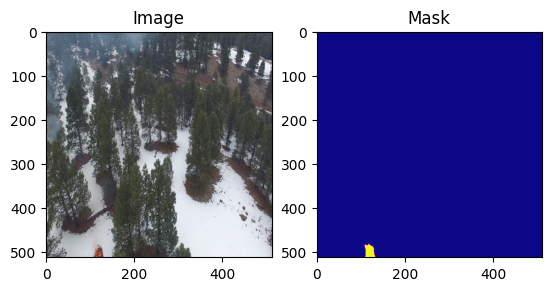

In [11]:
image_path = "Images"
mask_path = "Masks"

image_files = os.listdir(image_path)
mask_files = os.listdir(mask_path)

transform = transforms.Compose([transforms.ToTensor()])
dataset = FireDataset(image_path,mask_path, transform)
length = FireDataset.__len__(dataset)

# Assuming 'length' is the total number of samples in your dataset
length = len(dataset)

# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * length)
val_size = int(0.1 * length)
test_size = length - train_size - val_size

# Split the dataset into training, validation, and testing sets
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader instances for training, validation, and testing
batch_size = 32  # You can adjust this based on your needs
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_data.indices), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(dataset, val_data.indices), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_data.indices), batch_size=batch_size, shuffle=False)

print('Length of the Training set: '+str(len(train_data)))
print('Length of the Validation set: '+str(len(val_data)))
print('Length of the Testing set: '+str(len(test_data)))

# Printing one image and mask

# Assuming train_loader is your DataLoader
data_iterator = iter(train_loader)
batch = next(data_iterator)
image = batch[0]  # Assuming you want to visualize the first image in the batch
print(image.shape)
mask = batch[1]  # Assuming 'mask' is the key for your mask in the batch and it's one-dimensional
print(mask.shape)
# Assuming the image and mask are in CHW format (channels, height, width)
image = image[0].permute(1, 2, 0)  # Change to HWC for matplotlib

# Convert the torch tensors to NumPy arrays
image = image.numpy()
mask = mask.numpy()

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask[0][0], cmap='plasma')
plt.title('Mask')

plt.show()

In [12]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3, 16, 32, 64, 128, 256)):
        super(Encoder, self).__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32, 16)):
        super(Decoder, self).__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i + 1], kernel_size=2, stride=2) for i in range(len(chs) - 1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

class UNet(nn.Module):
    def __init__(self, enc_chs=(3, 16, 32, 64, 128, 256), dec_chs=(256, 128, 64, 32, 16), num_class=1, retain_dim=True, out_sz=(512, 512)):
        super(UNet, self).__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = nn.Conv2d(dec_chs[-1], num_class, kernel_size=1)
        self.retain_dim = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])

        out = self.head(out)

        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

model = UNet()
print(model)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): Max

In [13]:
def train(model, train_loader, val_loader, num_epochs, lr, device):
    # Move the model to the device
    model = nn.DataParallel(model)
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Record the start time of the epoch
        model.train()
        training_loss = 0.0

        for images, masks in train_loader:

            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs.squeeze(dim=1), masks.float().squeeze(dim=1))

            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        average_loss = training_loss / len(train_loader)

        # Save the model after training 1 epoch
        torch.save(model.state_dict(), "pytorch_model_{}.pth".format(epoch+1))

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for val_images, val_masks in val_loader:
                val_images, val_masks = val_images.to(device), val_masks.to(device)

                val_outputs = model(val_images)

                val_loss += criterion(val_outputs.squeeze(dim=1), val_masks.float().squeeze(dim=1)).item()

            average_val_loss = val_loss / len(val_loader)

            # Calculate Elapsed Time
            epoch_end_time = time.time()  # Record the end time of the epoch
            epoch_time = epoch_end_time - epoch_start_time  # Calculate the time taken for the epoch
            epoch_time_str = "{:0>2}:{:05.2f}".format(int(epoch_time // 60), epoch_time % 60)

            file_path = 'README.md'
            with open(file_path, 'a') as file:
                # Assuming you have the variables epoch, epochs, training_loss, training_accuracy, val_loss, and accuracy defined
                content = f"Epoch {epoch+1} ({epoch_time_str})- Training Loss: {average_loss:.4f} - Validation Loss: {average_val_loss:.4f}"

                # Print the content to the console
                print(content)

                # Write the content to the file
                print(content, file=file)

    print("Training complete.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model, train_loader, val_loader, num_epochs=60, lr=0.001, device=device)

Epoch 1 (00:20.07)- Training Loss: 0.1326 - Validation Loss: 0.0385
Epoch 2 (00:12.73)- Training Loss: 0.0351 - Validation Loss: 0.0345
Epoch 3 (00:12.81)- Training Loss: 0.0336 - Validation Loss: 0.0339
Epoch 4 (00:12.73)- Training Loss: 0.0351 - Validation Loss: 0.0355
Epoch 5 (00:12.72)- Training Loss: 0.0336 - Validation Loss: 0.0333
Epoch 6 (00:12.78)- Training Loss: 0.0322 - Validation Loss: 0.0311
Epoch 7 (00:12.72)- Training Loss: 0.0306 - Validation Loss: 0.0300
Epoch 8 (00:12.83)- Training Loss: 0.0284 - Validation Loss: 0.0285
Epoch 9 (00:12.92)- Training Loss: 0.0282 - Validation Loss: 0.0284
Epoch 10 (00:12.71)- Training Loss: 0.0268 - Validation Loss: 0.0260
Epoch 11 (00:12.89)- Training Loss: 0.0230 - Validation Loss: 0.0212
Epoch 12 (00:12.69)- Training Loss: 0.0200 - Validation Loss: 0.0191
Epoch 13 (00:12.76)- Training Loss: 0.0181 - Validation Loss: 0.0276
Epoch 14 (00:12.76)- Training Loss: 0.0202 - Validation Loss: 0.0177
Epoch 15 (00:12.74)- Training Loss: 0.0159 

Load the model

In [14]:
model_path = "pytorch_model_1.pth"
if model_path in files :
            # Load the model
            model = UNet()
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # If the model was saved with DataParallel, remove the 'module' prefix from keys
            state_dict = torch.load(model_path, map_location=device)
            #print(state_dict)
            if 'module' in list(state_dict.keys())[0]:
                state_dict = {k[7:]: v for k, v in state_dict.items()}

            model.load_state_dict(state_dict)

            # Move the model to the device
            model = model.to(device)

Print a Random Image

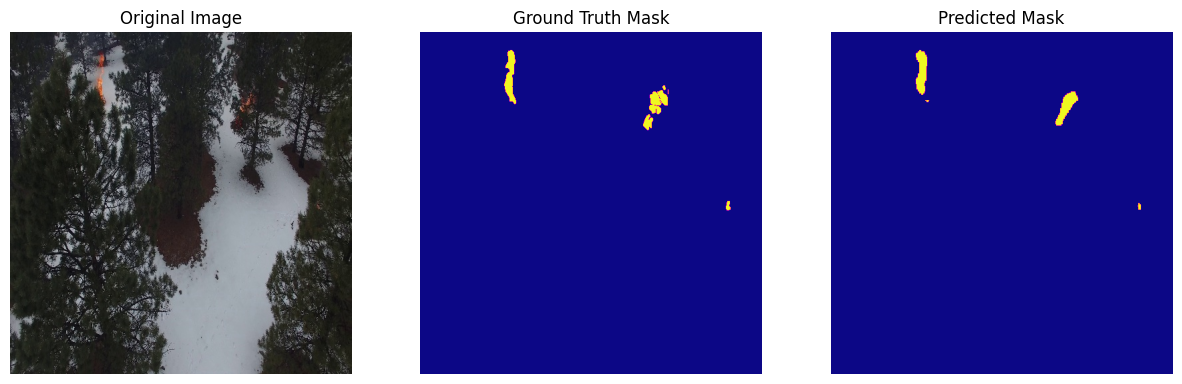

In [15]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
torch.set_printoptions(threshold = 5000000)
def visualize_random_prediction(model, test_loader, device):
  # Move the model to the device
    model = model.to(device)
    model.eval()

    # Choose a random index from the test set
    random_index = np.random.randint(0, len(test_loader.dataset))

    with torch.no_grad():
        # Get the random image and mask
        random_image, random_mask = test_loader.dataset[random_index]
        random_image = random_image.unsqueeze(0).to(device)

        # Make a prediction
        prediction = torch.sigmoid(model(random_image)).cpu().numpy()

    # Convert PyTorch tensors to numpy arrays
    random_image_np = TF.to_pil_image(random_image.squeeze())
    random_mask_np = TF.to_pil_image(random_mask.squeeze())
    tensor =  torch.tensor(prediction.squeeze())
    prediction_np = TF.to_pil_image(torch.where(tensor > 0.45, 1.0, 0.0))


    # Display the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(random_image_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(random_mask_np, cmap='plasma')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction_np, cmap='plasma')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Example usage
visualize_random_prediction(model, train_loader, device)


Do the Testing:

In [18]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

def test(model, test_loader, device):
    model.eval()
    model = model.to(device)
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            predictions = torch.sigmoid(outputs.squeeze(dim=1)).cpu().numpy()

            # Experimenting with different thresholds techniques
            # predictions = torch.sigmoid(outputs.squeeze(dim=1))
            # predictions = torch.where(predictions > 0.15, 1.0, 0.0).cpu().numpy()

            labels = masks.cpu().numpy()

            all_predictions.append(predictions)
            all_labels.append(labels)

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels).astype(int)  # Convert to integers
    all_labels = np.squeeze(all_labels,axis = 1)

    # Threshold predictions for binary classification
    binary_predictions = (all_predictions > 0.5).flatten()

    # Calculate metrics
    precision = precision_score(all_labels.flatten(), binary_predictions, zero_division=0) * 100
    recall = recall_score(all_labels.flatten(), binary_predictions) * 100
    f1 = f1_score(all_labels.flatten(), binary_predictions) * 100

    # Calculate AUC-ROC
    fpr, tpr, _ = roc_curve(all_labels.flatten(), all_predictions.flatten())
    auc_value = auc(fpr, tpr) * 100

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(all_labels.flatten(), (all_predictions > 0.5).flatten()).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100

    # Calculate IOU (Intersection over Union)
    intersection = np.sum(np.logical_and(all_predictions > 0.5, all_labels == 1))
    union = np.sum(np.logical_or(all_predictions > 0.5, all_labels == 1))
    iou = (intersection / union) * 100

    return precision, recall, auc_value, f1, sensitivity, specificity, iou

In [19]:
precision, recall, auc_value, f1, sensitivity, specificity, iou = test(model, test_loader, device)
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"AUC: {auc_value:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print(f"Sensitivity: {sensitivity:.2f}%")
print(f"Specificity: {specificity:.2f}%")
print(f"IOU: {iou:.2f}%")

Precision: 81.85%
Recall: 74.94%
AUC: 99.82%
F1-Score: 78.24%
Sensitivity: 74.94%
Specificity: 99.89%
IOU: 64.26%
